### Import

In [1]:
import json
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from glob import glob
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.tokenize import RegexpTokenizer
import re
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Download necessary NLTK data
nltk.download('punkt')
nltk.download('stopwords')

# Initialize NLTK's Porter stemmer
stemmer = PorterStemmer()

# Retrieve English stop words
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    # Tokenization and removing punctuation
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(text)
    
    # Stop words removal
    filtered_words = [w for w in tokens if not w in stop_words]
    
    # Stemming
    stemmed_words = [stemmer.stem(w) for w in filtered_words]
    
    # Normalization (here, just converting to lower case as an example)
    normalized_words = [w.lower() for w in stemmed_words]
    
    # Rejoin words
    return ' '.join(normalized_words)

# Specify the path to your dataset

# Write path to M4 folder
dataset_path = ("\M4")
print(os.path.join(dataset_path, "*.jsonl"))
all_files = glob(os.path.join(dataset_path, "*.jsonl"))

data = []
processed_sources = []  # Keep track of sources that have been processed

### Dealing with M4 dataset

In [ ]:
# Load and preprocess the data from JSONL files
for filename in all_files:
    # Extract source and model name from filename
    base = os.path.basename(filename)
    source, model_name = os.path.splitext(base)[0].split('_')
    
    with open(filename, 'r', encoding='utf-8') as file:
        print("Processing file: ", filename, " ...")
        for line in file:
            entry = json.loads(line)
            
            # Check if 'human_text' is null or if 'machine_text' is missing
            if entry['human_text'] is None or entry['machine_text'] is None:
                continue  # Skip this record
            
            # Note that there may have some case where human text is lower than prompt then append the last element
            # Otherwise, just ignore the extra elements
            if isinstance(entry['prompt'], list):
                #print("length of prompt, human_text, machine_text: ", len(entry['prompt']), len(entry['human_text']), len(entry['machine_text']))
                # if human text or machine text is null then continue
                # If the list lengths are not equal, just copy the last element to fill the list
                if len(entry['human_text']) < len(entry['prompt']):
                    entry['human_text'] = entry['human_text'] + [entry['human_text'][-1]] * (len(entry['prompt']) - len(entry['human_text']))
                if len(entry['machine_text']) < len(entry['prompt']):
                    entry['machine_text'] = entry['machine_text'] + [entry['machine_text'][-1]] * (len(entry['prompt']) - len(entry['machine_text']))
            
                for i in range(len(entry['prompt'])):
                    prompt = preprocess_text(entry['prompt'][i])
                    human_text = preprocess_text(entry['human_text'][i])
                    machine_text = preprocess_text(entry['machine_text'][i])
                    if source not in processed_sources:
                        data.append({"text": human_text, "label": 0, "prompt": prompt, "source": source, "model": "human", "dataset": "M4", "pure": "1"})
                    data.append({"text": machine_text, "label": 1, "prompt": prompt, "source": source, "model": model_name, "dataset": "M4", "pure": "1"})
            else:
                prompt = preprocess_text(entry['prompt'])
                human_text = preprocess_text(entry['human_text'])
                machine_text = preprocess_text(entry['machine_text'])
                if source not in processed_sources:
                    data.append({"text": human_text, "label": 0, "prompt": prompt, "source": source, "model": "human", "dataset": "M4", "pure": "1"})
                data.append({"text": machine_text, "label": 1, "prompt": prompt, "source": source, "model": model_name, "dataset": "M4", "pure": "1"})
            
        if source not in processed_sources:
            processed_sources.append(source)  # Mark this source as processed
# Convert to DataFrame
df = pd.DataFrame(data)

In [16]:
# Sample up to 3000 data points for each model-category group
sampled_df = pd.DataFrame()

for (model, source), group in df.groupby(['model', 'source']):
    if len(group) > 9000:
        sampled_group = group.sample(n=9000, random_state=42)
    else:
        sampled_group = group
    sampled_df = pd.concat([sampled_df, sampled_group], ignore_index=True)

# Since the current approach is to always load the human + Machine text without caring if the human is repeated or not, the overall result should be balanced

# Continue with dataset splitting and saving as before
train_val, test = train_test_split(sampled_df, test_size=0.2, random_state=42)
train, val = train_test_split(train_val, test_size=0.25, random_state=42)

# Save the updated datasets to CSV files
train.to_csv('train_balanced.csv', index=False)
val.to_csv('val_balanced.csv', index=False)
test.to_csv('test_balanced.csv', index=False)

print("Data processed, balanced, and oversampled, then split into training, validation, and test sets successfully.")

Data processed, balanced, and oversampled, then split into training, validation, and test sets successfully.


## MGTBench

In [ ]:
# Assuming existing imports and functions from your original script

# Write path to MGTBench
dataset_path = ("\\MGTBench")
all_files = glob(os.path.join(dataset_path, "*.csv"))

data = []

df = pd.DataFrame()

for file in all_files:
    print("Processing file ", file, " ...")
    # Determine the source based on the file name
    if 'Essay_LLMs.csv' in file:
        source = 'essay'
    elif 'Reuters_LLMs.csv' in file:
        source = 'news'
    elif 'WP_LLMs.csv' in file:
        source = 'story'
    else:
        print("Unknown source for file:", file)
        continue  # Skip this file if the source is unknown

    new_df = pd.read_csv(file)
    human_df = new_df[['id', 'prompt', 'human']].dropna(subset=['human'])
    gpt4_df = new_df[['id', 'prompt', 'GPT4All']].dropna(subset=['GPT4All'])
    chatgpt_df = new_df[['id', 'prompt', 'ChatGPT']].dropna(subset=['ChatGPT'])
    
    human_df['source'] = source
    gpt4_df['source'] = source
    chatgpt_df['source'] = source

    # Prepare the data for appending
    prepared_data = []
    for _, row in human_df.iterrows():
        prompt_processed = preprocess_text(row['prompt'])
        human_text_processed = preprocess_text(row['human'])
        # Append each human data entry twice for oversampling
        for _ in range(2):  # 2x oversampling
            prepared_data.append({
                "text": human_text_processed,
                "label": 0,  # Label for human data
                "prompt": prompt_processed,
                "source": row['source'],
                "model": "human",
                "dataset": "MGTBench",
                "pure": "1"
            })
    
    # Append ChatGPT data
    for _, row in chatgpt_df.iterrows():
        prompt_processed = preprocess_text(row['prompt'])
        chatgpt_text_processed = preprocess_text(row['ChatGPT'])
        prepared_data.append({
            "text": chatgpt_text_processed,
            "label": 1,
            "prompt": prompt_processed,
            "source": row['source'],
            "model": "chatGPT",
            "dataset": "MGTBench",
            "pure": "1"
        })
        
    for _, row in gpt4_df.iterrows():
        prompt_processed = preprocess_text(row['prompt'])
        gpt4_text_processed = preprocess_text(row['GPT4All'])
        prepared_data.append({
            "text": gpt4_text_processed,
            "label": 1,  # Assuming label for GPT4 data is 1
            "prompt": prompt_processed,
            "source": row['source'],
            "model": "GPT4",
            "dataset": "MGTBench",
            "pure": "1"
        })
    
    # Convert the prepared data to DataFrame and append to the existing data
    prepared_df = pd.DataFrame(prepared_data)
    if 'df' not in locals():  # Check if df does not exist yet
        df = prepared_df
    else:
        df = pd.concat([df, prepared_df], ignore_index=True)

# Creating the Out-of-Distribution Data
# Making test data from the prepared data
test = df.sample(frac=1, random_state=42)
test.to_csv('test_MGTBench.csv', index=False)

# Split the dataset after processing all files
#train_val, test = train_test_split(df, test_size=0.2, random_state=42)
#train, val = train_test_split(train_val, test_size=0.25, random_state=42)  # 0.25 x 0.8 = 0.2

# Optionally, save the updated datasets to CSV files
#train.to_csv('train.csv', index=False)
#val.to_csv('val.csv', index=False)
#test.to_csv('test.csv', index=False)

print("Data processed and split into training, validation, and test sets successfully, including new human and GPT4 data.")

## Mixset

In [30]:
import json
import pandas as pd
from sklearn.model_selection import train_test_split

# Write path to MixSet
dataset_path = "\\MixSet"  # Ensure this is updated to your dataset's path
json_files = [
    "gpt4_complete.json",
    "gpt4_humanize.json",
    "gpt4_polish_sentence.json",
    "gpt4_rewrite.json"
]

allowed_categories = {
    "gpt4_complete.json": ["blog", "news", "paper_abstract", "speech"],
    "gpt4_humanize.json": "all",  # For gpt4_humanize.json, we'll set the source as "QA" directly
    "gpt4_polish_sentence.json": ["blog", "news", "paper_abstract", "speech"],
    "gpt4_rewrite.json": ["blog", "news", "paper_abstract", "speech"]
}

df = pd.DataFrame()

for file_name in json_files:
    file_path = f"{dataset_path}/{file_name}"
    prepared_data = []  # Initialize an empty list for the new data
    print("Processing file ", file_name, " ...")
    
    with open(file_path, 'r') as file:
        data = json.load(file)
        
    method_name = file_name.replace("gpt4_", "").replace(".json", "")
    sentence_field = "HWT_sentence" if method_name != "humanize" else "MGT_sentence"
    output_field = f"gpt4_{method_name}_output"
    
    for item in data:
        category = item.get("category")
        if method_name == "humanize":
            source = "QA"
        else:
            if category == "paper_abstract":
                category = "essay"
            source = category
            
        if allowed_categories[file_name] == "all" or source in allowed_categories[file_name]:
            sentence = item.get(sentence_field, "")
            gpt4_output = item.get(output_field, "")
            
            if method_name == "humanize":
                # The humanized method is to use GPT4 to humanize the QA from other machine generated data from other dataset
                prepared_data.append({
                    "text": sentence,
                    "label": 1,
                    "prompt": "NA",
                    "source": source,
                    "model": "other",
                    "dataset": "Mixset" + method_name.upper(),
                    "pure": "1"
                })
                prepared_data.append({
                    "text": gpt4_output,
                    "label": 1,
                    "prompt": "NA",
                    "source": source,
                    "model": "GPT4",
                    "dataset": "Mixset" + method_name.upper(),
                    "pure": "0"
                })
            else:
                # Prepare and collect new data
                if sentence_field == "HWT_sentence":
                    prepared_data.append({
                        "text": sentence,
                        "label": 0,
                        "prompt": "NA",
                        "source": source,
                        "model": "human",
                        "dataset": "Mixset" + method_name.upper(),
                        "pure": "1"
                    })
                
                prepared_data.append({
                    "text": gpt4_output,
                    "label": 1,
                    "prompt": "NA",
                    "source": source,
                    "model": "GPT4",
                    "dataset": "Mixset" + method_name.upper(),
                    "pure": "0"
                })
                
    # Convert the prepared data to a DataFrame and append to the existing DataFrame
    prepared_df = pd.DataFrame(prepared_data) # Problem Always reset here
    df = pd.concat([df, prepared_df], ignore_index=True)

test = df.sample(frac=1, random_state=42)
#train.to_csv('train.csv', index=False)
#val.to_csv('val.csv', index=False)
test.to_csv('test_MixSet.csv', index=False)

#mixset_data = df[df['dataset'].str.contains("Mixset")]
#non_mixset_data = df[~df['dataset'].str.contains("Mixset")]

# Re-split and save your dataset as before
#train_val, non_mixset_test = train_test_split(non_mixset_data, test_size=0.2, random_state=42)
#train, val = train_test_split(train_val, test_size=0.25, random_state=42)

#test = pd.concat([non_mixset_test, mixset_data], ignore_index=True)

# Optionally, save the updated datasets to CSV files
#train.to_csv('train.csv', index=False)
#val.to_csv('val.csv', index=False)
#test.to_csv('test.csv', index=False)

print("Data processed and split into training, validation, and test sets successfully, with specific handling for JSON data.")


Processing file  gpt4_complete.json  ...
Processing file  gpt4_humanize.json  ...
Processing file  gpt4_polish_sentence.json  ...
Processing file  gpt4_rewrite.json  ...
Data processed and split into training, validation, and test sets successfully, with specific handling for JSON data.


                                                text  label  \
0  i cruel human i commit unspeak act pure i die ...      0   
1  accord lufkin 2021 urgent need reduc impact ph...      0   
2  whi i access playboy websit that say comput ex...      0   
3  in order gener proton gradient across inner mi...      1   
4  the concept cultur fundament phenomenon influe...      0   

                                              prompt source  model   dataset  \
0  write stori 500 word prompt you sentenc death ...  story  human  MGTBench   
1  write essay 400 word prompt write essay analyz...  essay  human  MGTBench   
2  write news articl 700 word base headlin china ...   news  human  MGTBench   
3  write essay 300 word prompt how transfer elect...  essay   GPT4  MGTBench   
4  write essay 300 word prompt examin social fact...  essay  human  MGTBench   

   pure  
0     1  
1     1  
2     1  
3     1  
4     1  
6000


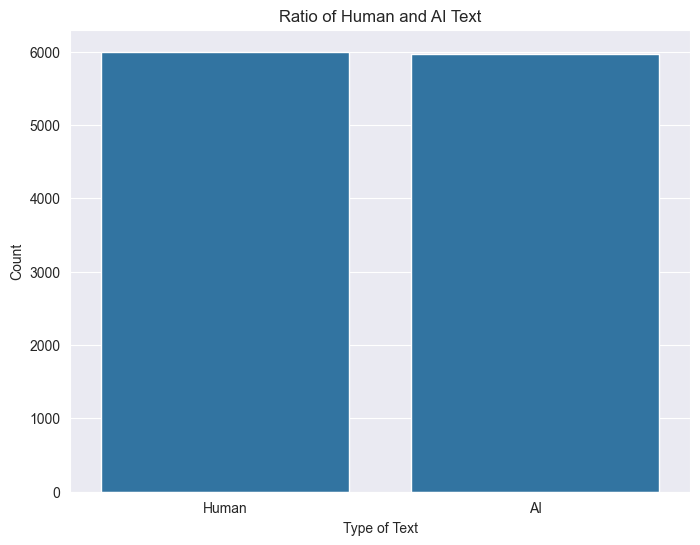

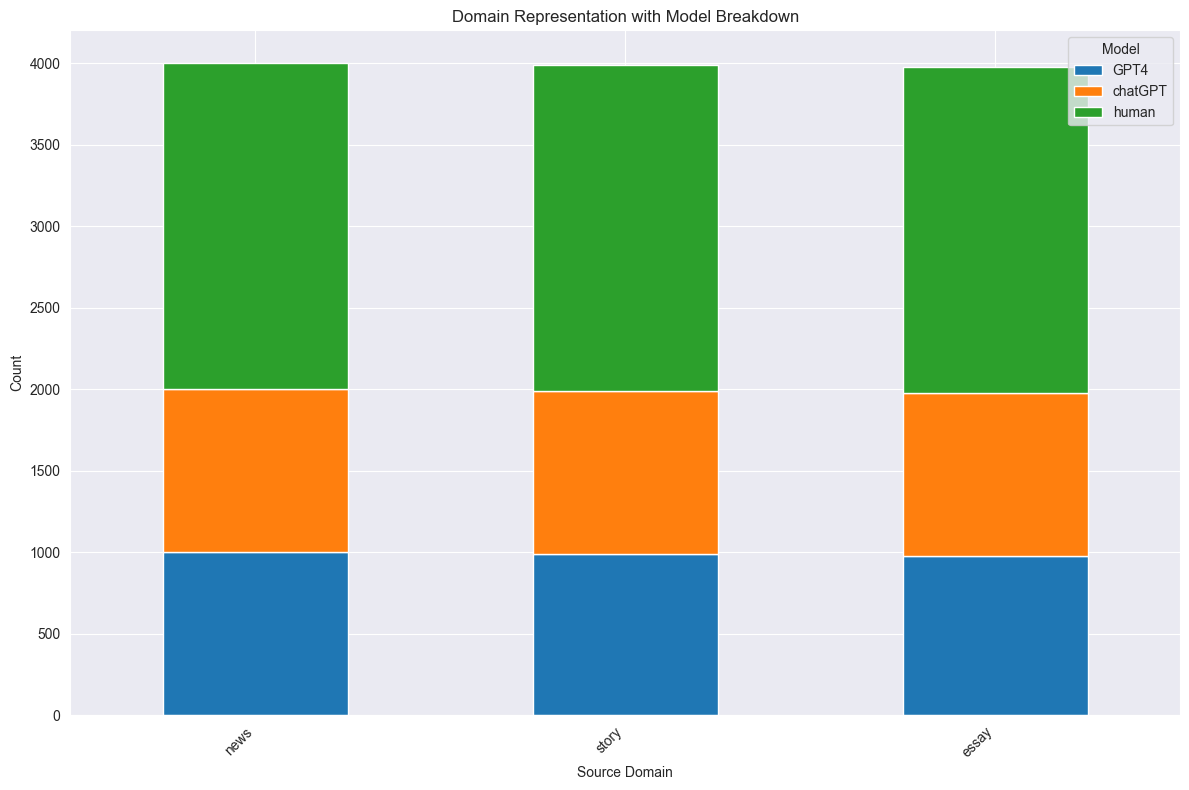

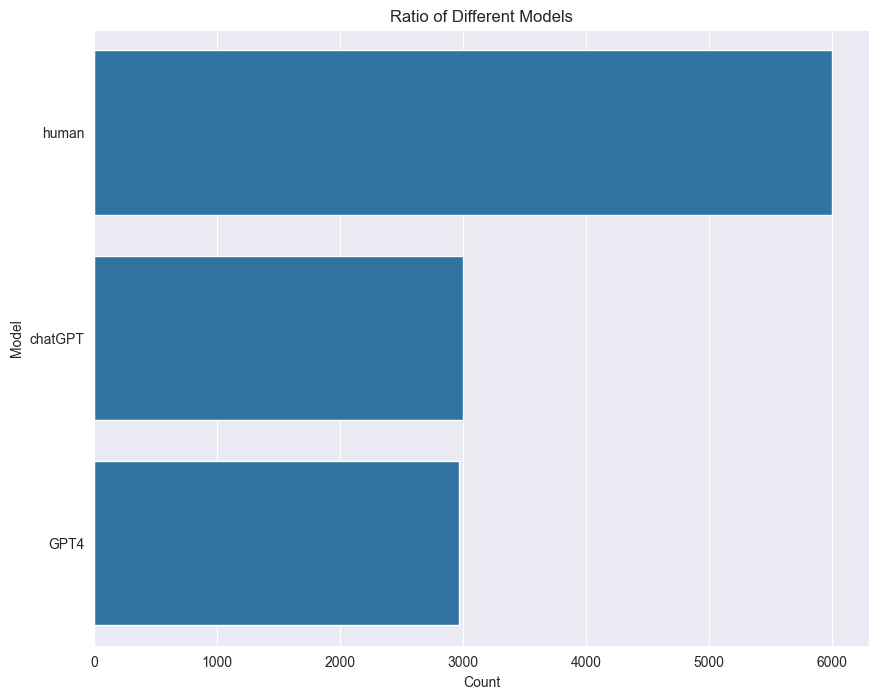

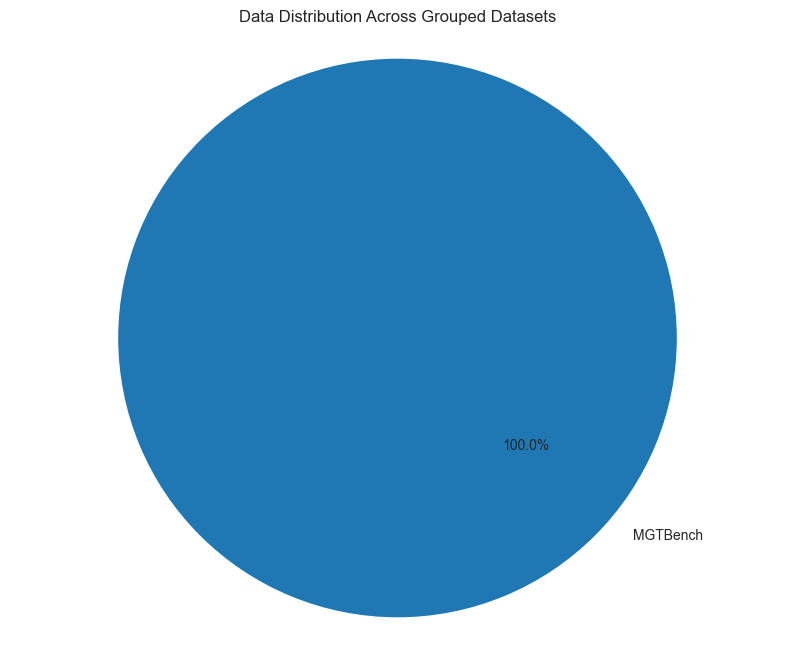

  source    model  count
0  essay     GPT4    976
1  essay  chatGPT   1000
2  essay    human   2000
3   news     GPT4   1000
4   news  chatGPT   1000
5   news    human   2000
6  story     GPT4    989
7  story  chatGPT   1000
8  story    human   2000


In [32]:
# Load the datasets
#train = pd.read_csv('train_balanced.csv')
#val = pd.read_csv('val_balanced.csv')
#test = pd.read_csv('test_balanced.csv')

test = pd.read_csv('test_MGTBench.csv')

# Remove rows where the 'text' column is NaN from train, val, and test datasets
#train = train.dropna(subset=['text'])
#val = val.dropna(subset=['text'])
#test = test.dropna(subset=['text'])

test = test.dropna(subset=['text'])

# You may want to reset the index after dropping rows
#train = train.reset_index(drop=True)
#val = val.reset_index(drop=True)
test = test.reset_index(drop=True)

# Combine the datasets for overall statistics
all_data = pd.concat([test], ignore_index=True)
print(all_data.head())
print(all_data[all_data['label'] == 0].shape[0])
# 1. Ratio of human and AI text
plt.figure(figsize=(8, 6))
sns.countplot(x='label', data=all_data)
plt.title('Ratio of Human and AI Text')
plt.xticks([0, 1], ['Human', 'AI'])
plt.xlabel('Type of Text')
plt.ylabel('Count')
plt.show()

# 2. Ratio of different domain sources
# Group the data by 'source' and 'model' and get the size of each group
model_domain_counts = all_data.groupby(['source', 'model']).size().unstack(fill_value=0)

# Calculate total counts for each domain by summing across models
total_counts_by_domain = model_domain_counts.sum(axis=1)

# Sort domains by total counts in descending order
sorted_domains = total_counts_by_domain.sort_values(ascending=False).index

# Reindex the DataFrame to reflect this order
model_domain_counts_sorted = model_domain_counts.reindex(sorted_domains)

# Now plot the sorted DataFrame
model_domain_counts_sorted.plot(kind='bar', stacked=True, figsize=(12, 8))

plt.title('Domain Representation with Model Breakdown')
plt.xlabel('Source Domain')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')  # Rotate domain names for better readability
plt.legend(title='Model')

plt.tight_layout()  # Adjust layout to make room for the rotated domain names
plt.show()

# 3. Ratio of different models
plt.figure(figsize=(10, 8))
sns.countplot(y='model', data=all_data, order = all_data['model'].value_counts().index)
plt.title('Ratio of Different Models')
plt.xlabel('Count')
plt.ylabel('Model')
plt.show()

# 4. Show the dataset distribution
# Preprocess 'dataset' column to group all "Mixset" related data under a single category "Mixset"
all_data['dataset_grouped'] = all_data['dataset'].apply(lambda x: 'Mixset' if 'Mixset' in x else x)

# Aggregate data by the newly created 'dataset_grouped'
dataset_distribution_grouped = all_data['dataset_grouped'].value_counts()

# Plot pie chart for the grouped dataset distribution
plt.figure(figsize=(10, 8))
plt.pie(dataset_distribution_grouped, labels=dataset_distribution_grouped.index, autopct='%1.1f%%', startangle=140)
plt.title('Data Distribution Across Grouped Datasets')
plt.axis('equal')  # Ensures the pie chart is circular
plt.show()

# Print the number of entries for each model within each domain
model_domain_counts = all_data.groupby(['source', 'model']).size().reset_index(name='count')
print(model_domain_counts)

In [72]:
train.head()

,text,label,prompt,source,model
0,when type password log comput send password se...,1,write coupl paragraph least 500 charact addres...,reddit,cohere
1,archimed commonli known variou contribut mathe...,1,i ask question for question provid 200 word an...,reddit,chatGPT
2,instal rocketfish tv mount fairli straightforw...,1,gener wikihow articl minimum 200 word titl how...,wikihow,cohere
3,actual interest topic whilst good number insul...,0,i ask question for question provid 200 word an...,reddit,human
4,how make pickl egg pickl egg great addit varie...,1,gener wikihow articl minimum 200 word titl how...,wikihow,cohere


In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer


X_train_texts = train['text']
y_train = train['label']
X_test_texts = test['text']
y_test = test['label']

# Transform text data into TF-IDF features
vectorizer = TfidfVectorizer(max_features=1000)  # You can tune this
X_train = vectorizer.fit_transform(X_train_texts).toarray()
X_test = vectorizer.transform(X_test_texts).toarray()

# SVM Classifier with RBF Kernel
clf_rbf = SVC(kernel='rbf')
clf_rbf.fit(X_train, y_train)
y_pred_rbf = clf_rbf.predict(X_test)

# Overall accuracy
print("Overall Accuracy (RBF Kernel):", accuracy_score(y_test, y_pred_rbf))

# Accuracy by model
for model_name in test['model'].unique():
    mask = test['model'] == model_name
    print(f"Accuracy for model {model_name}: {accuracy_score(y_test[mask], y_pred_rbf[mask])}")

# Accuracy by domain
for domain_name in test['source'].unique():
    mask = test['source'] == domain_name
    print(f"Accuracy for domain {domain_name}: {accuracy_score(y_test[mask], y_pred_rbf[mask])}")

# Confusion matrix for more insights, particularly false positives
cm = confusion_matrix(y_test, y_pred_rbf)
print("Confusion Matrix (RBF Kernel):\n", cm)
fp_rbf = cm[0][1]  # False positives: human texts misclassified as AI-generated
print(f"False Positives (Human as AI, RBF Kernel): {fp_rbf}")

# If needed, repeat the training and evaluation for other kernels, e.g., linear and polynomial
# Just replace 'kernel='rbf' with 'kernel='linear' or 'kernel='poly' in the SVC constructor

# For instance, training with a linear kernel
clf_linear = SVC(kernel='linear')
clf_linear.fit(X_train, y_train)
y_pred_linear = clf_linear.predict(X_test)
print("Overall Accuracy (Linear Kernel):", accuracy_score(y_test, y_pred_linear))


In [ ]:
import json
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from glob import glob
import torch
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from collections import Counter
from sklearn.metrics import precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

# Define necessary methods and classes for data handling and preprocessing
def build_dictionary(texts, vocab_size):
    counter = Counter()
    for line in texts:
        counter.update(line.split())
    words = [word for word, _ in counter.most_common(vocab_size)]
    word2idx = {word: idx + 2 for idx, word in enumerate(words)}
    word2idx['<PAD>'] = 0
    word2idx['<UNK>'] = 1
    return word2idx

class CustomTextDataset(Dataset):
    def __init__(self, texts, labels, dictionary):
        self.x = [[dictionary.get(word, dictionary['<UNK>']) for word in text.split()] for text in texts]
        self.y = labels
    def __len__(self):
        return len(self.x)
    def __getitem__(self, idx):
        return torch.tensor(self.x[idx], dtype=torch.long), torch.tensor(self.y[idx], dtype=torch.long)

def collate_fn(batch):
    batch_x, batch_y = zip(*batch)
    batch_x_padded = pad_sequence(batch_x, batch_first=True, padding_value=0)
    return batch_x_padded, torch.tensor(batch_y, dtype=torch.long)

# Data loading and preprocessing
dataset_path = "your_dataset_directory"  # Modify this path
train_df = pd.read_csv(os.path.join(dataset_path, 'train.csv')).dropna(subset=['text'])
val_df = pd.read_csv(os.path.join(dataset_path, 'val.csv')).dropna(subset=['text'])
test_df = pd.read_csv(os.path.join(dataset_path, 'test.csv')).dropna(subset=['text'])

# Combine train, val, and test data temporarily to build a comprehensive vocabulary
all_texts = pd.concat([train_df['text'], val_df['text'], test_df['text']], axis=0)
vocab_size = 8000  # You can adjust this
word2idx = build_dictionary(all_texts, vocab_size)

# Split the data back and prepare datasets
train_dataset = CustomTextDataset(train_df['text'].tolist(), train_df['label'].tolist(), word2idx)
val_dataset = CustomTextDataset(val_df['text'].tolist(), val_df['label'].tolist(), word2idx)
test_dataset = CustomTextDataset(test_df['text'].tolist(), test_df['label'].tolist(), word2idx)

# Data loaders
batch_size = 64  # Modify based on your needs and memory capacity
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

class RCNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size, dropout):
        super(RCNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(embedding_dim, hidden_size, batch_first=True, bidirectional=True, dropout=dropout)
        self.W = nn.Linear(embedding_dim + 2*hidden_size, hidden_size)
        self.tanh = nn.Tanh()
        self.fc = nn.Linear(hidden_size, 2)  # 2 classes for binary classification

    def forward(self, x):
        x = self.embedding(x)
        lstm_out, _ = self.lstm(x)
        x = torch.cat((lstm_out, x), 2)
        x = self.tanh(self.W(x)).transpose(1, 2)
        x = F.max_pool1d(x, x.size(2)).squeeze(2)
        x = self.fc(x)
        return x

def evaluate_metrics(model, loader, device):
    model.eval()
    total_correct = 0
    total = 0
    all_predicted, all_labels = [], []
    with torch.no_grad():
        for texts, labels in loader:
            texts, labels = texts.to(device), labels.to(device)
            outputs = model(texts)
            predicted = torch.argmax(outputs, axis=1)
            total_correct += (predicted == labels).sum().item()
            total += labels.size(0)
            all_predicted.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    accuracy = total_correct / total
    precision = precision_score(all_labels, all_predicted)
    recall = recall_score(all_labels, all_predicted)
    f1 = f1_score(all_labels, all_predicted)
    return accuracy, precision, recall, f1

def train_and_evaluate(model, train_loader, val_loader, optimizer, device, epochs):
    history = {'train_loss': [], 'val_accuracy': [], 'val_precision': [], 'val_recall': [], 'val_f1': []}
    best_val_f1 = 0
    for epoch in range(1, epochs + 1):
        model.train()
        total_loss = 0
        for texts, labels in train_loader:
            texts, labels = texts.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(texts)
            loss = F.cross_entropy(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        average_loss = total_loss / len(train_loader)
        
        val_accuracy, val_precision, val_recall, val_f1 = evaluate_metrics(model, val_loader, device)
        
        history['train_loss'].append(average_loss)
        history['val_accuracy'].append(val_accuracy)
        history['val_precision'].append(val_precision)
        history['val_recall'].append(val_recall)
        history['val_f1'].append(val_f1)

        print(f'Epoch {epoch}/{epochs}, Training loss: {average_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}, Precision: {val_precision:.4f}, Recall: {val_recall:.4f}, F1: {val_f1:.4f}')
        
        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            print(f'New best validation F1: {best_val_f1:.4f}, saving model...')
            torch.save(model.state_dict(), 'best_model.pth')
    return history


def evaluate(model, loader, device):
    model.eval()
    total_correct = 0
    total = 0
    with torch.no_grad():
        for texts, labels in loader:
            texts, labels = texts.to(device), labels.to(device)
            outputs = model(texts)
            predicted = torch.argmax(outputs, axis=1)
            total_correct += (predicted == labels).sum().item()
            total += labels.size(0)
    accuracy = total_correct / total
    print(f'Accuracy: {accuracy:.4f}')
    return accuracy

# Main training loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
embedding_dim = 300
hidden_size = 128
dropout = 0.5
model = RCNN(vocab_size=vocab_size, embedding_dim=embedding_dim, hidden_size=hidden_size, dropout=dropout).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
epochs = 10  # You can adjust this

# Now, add the plotting part after your training loop:
history = train_and_evaluate(model, train_loader, val_loader, optimizer, device, epochs)
# Evaluate the model on the test set
test_accuracy, test_precision, test_recall, test_f1 = evaluate_metrics(model, test_loader, device)
print(f'Test Metrics - Accuracy: {test_accuracy:.4f}, Precision: {test_precision:.4f}, Recall: {test_recall:.4f}, F1: {test_f1:.4f}')

# Save the test metrics for plotting
test_metrics = {
    'accuracy': test_accuracy,
    'precision': test_precision,
    'recall': test_recall,
    'f1': test_f1
}

def plot_metrics(history, test_metrics):
    plt.figure(figsize=(15, 5))

    # Training Loss
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.title('Train Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Validation and Test Metrics
    plt.subplot(1, 2, 2)
    epochs = range(1, len(history['val_accuracy']) + 1)
    plt.plot(epochs, history['val_accuracy'], label='Validation Accuracy')
    plt.plot(epochs, history['val_precision'], label='Validation Precision')
    plt.plot(epochs, history['val_recall'], label='Validation Recall')
    plt.plot(epochs, history['val_f1'], label='Validation F1 Score')
    plt.axhline(test_metrics['accuracy'], color='r', linestyle='--', label='Test Accuracy')
    plt.axhline(test_metrics['precision'], color='g', linestyle='--', label='Test Precision')
    plt.axhline(test_metrics['recall'], color='b', linestyle='--', label='Test Recall')
    plt.axhline(test_metrics['f1'], color='y', linestyle='--', label='Test F1 Score')
    plt.title('Validation and Test Metrics')
    plt.xlabel('Epochs')
    plt.ylabel('Metrics')
    plt.legend()

    plt.show()

plot_metrics(history, test_metrics)